In [7]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pgeocode
import os
nomi = pgeocode.Nominatim('IN')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split as tts,cross_val_score,ShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,f1_score,classification_report,roc_auc_score
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)

In [8]:
 # Some tweaks for displaying large rows
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [9]:
# If DataSet lies in another Directory
#os.getcwd()
os.chdir("C:\\Users\\Dashang\\Documents\\GreyAtom_Capstone_MahindraFirst\\") 

In [11]:
invoice = pd.read_csv("invoice_final.csv")   ## Pre-Cleaned DataSet

In [12]:
invoice.head()

,model,customer_type,customer_no,gate_pass_time,invoice_no,job_card_no,km_reading,labour_total,make,order_type,pin_code,plant_code,plant_name,regn_no,total_amt,user_id,pin_city,pin_district,pin_location,latitude,longitude,state,zones,invoice_datetime,jobcard_datetime,Service_Time,model_type
0,spark,retail,67849,0:00:00,7005200002,168303,49317,1203.14,general motors,paid service,400601,bc01,thane,ka19ma1291,4051.95,bc01fs1,Thane,Maharashtra,"Thane Bazar, Thane H.O, Thane R.S.",19.1941,73.0002,maharashtra,west zone,01/02/15 11:30,12/13/2014 14:29,19 days 21:00:53.000000000,hatchback
1,indica,retail,84419,0:00:00,7005200003,173997,78584,804.26,tata motors,smc value package,400603,bc01,thane,mh43r3046,1001.29,bc01sa2,Thane,Maharashtra,"Thane East, Kopri Colony",19.1941,73.0002,maharashtra,west zone,01/03/15 10:07,01/02/15 14:12,0 days 19:55:14.000000000,hatchback
2,zen,retail,81055,0:00:00,7005200004,173889,33985,180.19,maruti suzuki,running repairs,400607,bc01,thane,ap09ax0582,233.14,bc01sa2,Thane,Maharashtra,"Chitalsar Manpada, Sandozbaugh",19.1941,73.0002,maharashtra,west zone,01/03/15 11:12,01/02/15 11:40,0 days 23:32:13.000000000,hatchback
3,indica,retail,84419,0:00:00,7005200005,174158,78584,0.00,tata motors,smc redemption,400603,bc01,thane,mh43r3046,0.00,bc01sa2,Thane,Maharashtra,"Thane East, Kopri Colony",19.1941,73.0002,maharashtra,west zone,01/03/15 11:40,01/03/15 10:12,0 days 01:28:12.000000000,hatchback
4,santro xing,retail,18980,0:00:00,7005200006,173860,50057,1202.97,hyundai,paid service,400603,bc01,thane,mh04cd9768,2747.12,bc01sa2,Thane,Maharashtra,"Thane East, Kopri Colony",19.1941,73.0002,maharashtra,west zone,01/03/15 12:07,01/02/15 10:45,1 days 01:21:35.000000000,hatchback


In [14]:

invoice['year'] = pd.to_datetime(invoice['invoice_datetime']).dt.year
invoice['month'] = pd.to_datetime(invoice['invoice_datetime']).dt.month
invoice["invoice_datetime"]=pd.to_datetime(invoice["invoice_datetime"],dayfirst=True)
invoice["jobcard_datetime"]=pd.to_datetime(invoice["jobcard_datetime"],dayfirst=True)
invoice['Service_Time'] = invoice['invoice_datetime'] - invoice['jobcard_datetime']
invoice['service_time_hrs'] = invoice['Service_Time']/np.timedelta64(1,'h')
invoice['service_time_hrs'].describe()

count    492314.000000
mean        131.710114
std        1367.364722
min       -8019.666667
25%           1.683333
50%           6.550000
75%          76.633333
max       18869.066667
Name: service_time_hrs, dtype: float64

In [16]:
invoice[invoice['service_time_hrs']<0]

,model,customer_type,customer_no,gate_pass_time,invoice_no,job_card_no,km_reading,labour_total,make,order_type,pin_code,plant_code,plant_name,regn_no,total_amt,user_id,pin_city,pin_district,pin_location,latitude,longitude,state,zones,invoice_datetime,jobcard_datetime,Service_Time,model_type,year,month,service_time_hrs
90,verito,retail,85739,0:00:00,7005200092,176658,36542,2067.06,mahindra & mahindra,running repairs,400603,bc01,thane,mh04ff2490,7907.01,bc01sa2,Thane,Maharashtra,"Thane East, Kopri Colony",19.1941,73.0002,maharashtra,west zone,2015-01-14 10:43:00,2015-11-01 12:58:00,-292 days +21:45:00,sedan,2015,1,-6986.250000
93,spark,retail,24772,0:00:00,7005200095,176674,48724,4072.96,general motors,paid service,400610,bc01,thane,mh04dw4163,11663.68,bc01sa1,Thane,Maharashtra,Apna Bazar,19.1941,73.0002,maharashtra,west zone,2015-01-14 18:28:00,2015-11-01 13:50:00,-291 days +04:38:00,hatchback,2015,1,-6979.366667
97,indigo,retail,84536,0:00:00,7005200099,174213,85000,7578.06,tata motors,paid service,600406,bc01,thane,mh12et826,30803.86,bc01sa2,Thane,Maharashtra,"Kalyan Rs, Kalyan City H.O, Subhash Road (Than...",19.2166,73.2176,maharashtra,west zone,2015-01-15 11:25:00,2015-03-01 11:15:00,-45 days +00:10:00,compact sedan,2015,1,-1079.833333
98,getz,retail,10606,0:00:00,7005200100,176960,94332,2354.89,hyundai,paid service,400607,bc01,thane,ka03me2047,7537.85,bc01sa2,Thane,Maharashtra,"Chitalsar Manpada, Sandozbaugh",19.1941,73.0002,maharashtra,west zone,2015-01-15 13:52:00,2015-12-01 13:57:00,-321 days +23:55:00,hatchback,2015,1,-7680.083333
101,swift,retail,85933,0:00:00,7005200103,177046,37093,175.01,maruti suzuki,accidental,400614,bc01,thane,mh43aj9033,5825.87,bc01fs1,Thane,Maharashtra,"Belapur Node-- III, Konkan Bhavan, Belapur Nod...",19.1941,73.0002,maharashtra,west zone,2015-01-15 16:07:00,2015-12-01 16:28:00,-321 days +23:39:00,hatchback,2015,1,-7680.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492186,wagonr,retail,185128,0:00:00,7215600177,368459,88871,1200.00,maruti suzuki,paid service,384002,x328,x328 - pramukh auto,gj02bd708,1200.00,x328wm1,Mahesana,Gujarat,"Mahesana I E, Mahesana Railway Colony",23.8153,73.1628,gujarat,west zone,2016-06-29 17:45:00,2016-10-05 16:47:00,-98 days +00:58:00,hatchback,2016,6,-2351.033333
492187,santro,retail,184674,0:00:00,7215600178,367718,85352,2865.24,hyundai,paid service,384002,x328,x328 - pramukh auto,gj18ah2397,2865.24,x328sa1,Mahesana,Gujarat,"Mahesana I E, Mahesana Railway Colony",23.8153,73.1628,gujarat,west zone,2016-06-29 17:48:00,2016-09-05 15:34:00,-68 days +02:14:00,hatchback,2016,6,-1629.766667
492188,indigo manza,retail,185608,0:00:00,7215600179,369373,64098,1200.00,tata motors,paid service,384002,x328,x328 - pramukh auto,gj02bh1881,1200.00,x328wm1,Mahesana,Gujarat,"Mahesana I E, Mahesana Railway Colony",23.8153,73.1628,gujarat,west zone,2016-06-29 17:52:00,2016-12-05 10:51:00,-159 days +07:01:00,sedan,2016,6,-3808.983333
492189,eeco,retail,185674,0:00:00,7215600180,369482,67428,1404.40,maruti suzuki,paid service,384002,x328,x328 - pramukh auto,gj02ap4634,1404.40,x328wm1,Mahesana,Gujarat,"Mahesana I E, Mahesana Railway Colony",23.8153,73.1628,gujarat,west zone,2016-06-29 17:55:00,2016-12-05 11:49:00,-159 days +06:06:00,minivan,2016,6,-3809.900000


In [17]:
new_invoice=invoice[invoice['service_time_hrs']>0]

### Calculation of Life Time Value for the year 2015

In [18]:
invoice_2015=invoice[invoice["year"]==2015]

In [20]:
# Calculating frequency of visits & total revenue of a customer for calculation of ltv

customer_freq=invoice_2015.groupby(["make","model","pin_location","customer_no"]).agg({"invoice_no":'nunique',"total_amt":'mean',"service_time_hrs":'mean'})
customer_freq=customer_freq.reset_index()

customer_freq.head()

ltv_make_model_r=customer_freq.copy()
ltv_make_model_r["LTV"] = ltv_make_model_r["invoice_no"] * ltv_make_model_r["total_amt"]
ltv_make_model_r.head()

,make,model,pin_location,customer_no,invoice_no,total_amt,service_time_hrs,LTV
0,audi,a4,"Anandibazar, Ahmednagar City, Ahmednagar H.O, ...",118262,1,1754.440,0.266667,1754.44
1,audi,a4,"Anandibazar, Ahmednagar City, Ahmednagar H.O, ...",129425,1,263.160,1.800000,263.16
2,audi,a4,"Block 5,Neyveli, Block 26,Neyveli, Block 18,Ne...",121383,2,6126.835,55.500000,12253.67
3,audi,a4,"Deccan Gymkhana, Film Institute, A.R. Shala",98005,1,14549.910,2959.950000,14549.91
4,audi,a4,"Dharmapuri Collectorate, Vennampatti, Venkaten...",99532,4,934.705,985.020833,3738.82


### Filtering customer having LTV > 0 

In [21]:
ltv_make_model_r = ltv_make_model_r[ltv_make_model_r['LTV'] > 0]

In [22]:
print("0.05 quantile :-",ltv_make_model_r['LTV'].quantile(0.05))
print("0.25 quantile :-",ltv_make_model_r['LTV'].quantile(0.25))
print("0.50 quantile :-",ltv_make_model_r['LTV'].quantile(0.50))
print("0.75 quantile :-",ltv_make_model_r['LTV'].quantile(0.75))
print("0.95 quantile :-",ltv_make_model_r['LTV'].quantile(0.95))
print("minimum LTV :-",ltv_make_model_r['LTV'].min())
print("maximum LTV :-",ltv_make_model_r['LTV'].max())
print("mean LTV :-",ltv_make_model_r['LTV'].mean())

0.05 quantile :- 195.144
0.25 quantile :- 748.56
0.50 quantile :- 2921.11
0.75 quantile :- 8045.9
0.95 quantile :- 30092.43399999998
minimum LTV :- 0.85
maximum LTV :- 1635707.79
mean LTV :- 7855.861692815374


In [ ]:
print(ltv_make_model_r[ltv_make_model_r["LTV"]<=2921.11].shape)
print(ltv_make_model_r[(ltv_make_model_r["LTV"]>2921.11)&(ltv_make_model_r["LTV"]<=8045.9)].shape)
print(ltv_make_model_r[ltv_make_model_r["LTV"]>8045.9].shape)

In [23]:
bins=[-1,2921.11,8045.9,1635707.79]
labels=["Low","Medium","High"]
ltv_make_model_r["LTV Binned"]=pd.cut(ltv_make_model_r["LTV"], bins=bins, labels=labels)

In [24]:
ltv_make_model_r["LTV Binned"].value_counts(dropna=False)

Low       37255
High      18627
Medium    18627
Name: LTV Binned, dtype: int64

In [25]:
ltv_make_model_r.dropna(inplace=True)

In [26]:
temp_ltv_make_model_r=ltv_make_model_r.copy()

In [27]:
le=LabelEncoder()
temp_ltv_make_model_r["make"]=le.fit_transform(temp_ltv_make_model_r["make"])
temp_ltv_make_model_r["model"]=le.fit_transform(temp_ltv_make_model_r["model"])
temp_ltv_make_model_r["LTV Binned"]=le.fit_transform(temp_ltv_make_model_r["LTV Binned"])
temp_ltv_make_model_r["pin_location"]=le.fit_transform(temp_ltv_make_model_r["pin_location"])

In [28]:
temp_ltv_make_model_r.head()

,make,model,pin_location,customer_no,invoice_no,total_amt,service_time_hrs,LTV,LTV Binned
0,0,7,123,118262,1,1754.440,0.266667,1754.44,1
1,0,7,123,129425,1,263.160,1.800000,263.16,1
2,0,7,371,121383,2,6126.835,55.500000,12253.67,0
3,0,7,582,98005,1,14549.910,2959.950000,14549.91,0
4,0,7,631,99532,4,934.705,985.020833,3738.82,2


In [29]:
X=temp_ltv_make_model_r.drop(["customer_no","LTV","LTV Binned","invoice_no"],1)
y=temp_ltv_make_model_r["LTV Binned"]

In [30]:
X_train,X_test,y_train,y_test=tts(X,y,test_size=0.3,random_state=0)

### Decision Tree Classifier

In [31]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=8,random_state=0)

dt.fit(X_train,y_train)

y_pred_dt = dt.predict(X_test)
y_pred_dt_train = dt.predict(X_train)

print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

           0       0.93      0.77      0.84      5561
           1       0.88      0.99      0.93     11205
           2       0.77      0.72      0.74      5587

    accuracy                           0.86     22353
   macro avg       0.86      0.82      0.84     22353
weighted avg       0.87      0.86      0.86     22353



In [32]:
print("test Accuracy :-" , accuracy_score(y_test,y_pred_dt))
print("train Accuracy :-" ,accuracy_score(y_train,y_pred_dt_train))

Training Accuracy :- 0.8647161454838277
Testing Accuracy :- 0.8715200552189585


<BarContainer object of 5 artists>

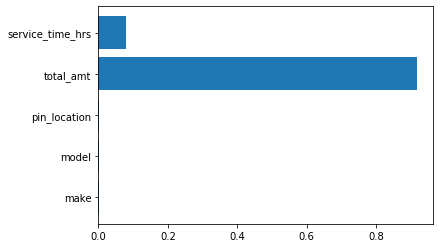

In [33]:
plt.barh(list(X),list(dt.feature_importances_))

In [34]:
### Cross Validation Score

dt_cv_score=cross_val_score(estimator=dt,X=X,y=y,cv=5)

print(dt_cv_score.mean())

0.8585273190927524


### Random Forest Classifier

In [36]:
rfc=RandomForestClassifier(criterion='entropy',max_depth=8,random_state=0)
rfc.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, random_state=0)

In [37]:
y_pred_rfc=rfc.predict(X_test)

In [38]:
print(classification_report(y_test,y_pred_rfc))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82      5561
           1       0.86      1.00      0.92     11205
           2       0.75      0.70      0.72      5587

    accuracy                           0.85     22353
   macro avg       0.86      0.81      0.82     22353
weighted avg       0.86      0.85      0.85     22353



In [39]:
accuracy_score(y_test,y_pred_rfc)

0.8537556480114527

In [41]:
print("test Accuracy :-" , accuracy_score(y_test,y_pred_rfc))
print("train Accuracy :-" ,accuracy_score(y_train,rfc.predict(X_train)))

test Accuracy :- 0.8537556480114527
train Accuracy :- 0.8608213820078227


<BarContainer object of 5 artists>

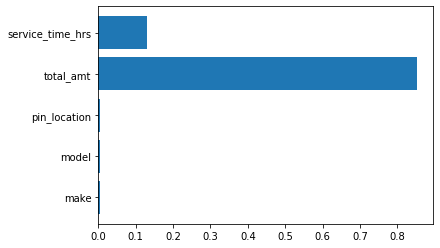

In [40]:
plt.barh(list(X),list(rfc.feature_importances_))

### XgBoost Classifier

In [42]:
xgb=XGBClassifier()

In [43]:
xgb.fit(X_train,y_train)

XGBClassifier(objective='multi:softprob')

In [44]:
y_pred_xgb=xgb.predict(X_test)

In [45]:
print("test Accuracy :-" , accuracy_score(y_test,xgb.predict(X_test)))
print("train Accuracy :-" ,accuracy_score(y_train,xgb.predict(X_train)))

test Accuracy :- 0.8631950968550083
train Accuracy :- 0.8668993020937188


In [46]:
print(classification_report(y_test,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.94      0.75      0.84      5561
           1       0.88      0.99      0.93     11205
           2       0.76      0.72      0.74      5587

    accuracy                           0.86     22353
   macro avg       0.86      0.82      0.84     22353
weighted avg       0.86      0.86      0.86     22353

